# **SARIMA model for Predicting Stock Price** [](https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775)

# **Part 1: Data Loading and Preprocessing**
New Germany Fund data from [Yahoo Finance](https://finance.yahoo.com/quote/GF/history?p=GF)

## 1.1 Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
%matplotlib inline

from google.colab import drive
drive.mount('ggDrive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at ggDrive


In [2]:
fnm = 'ggDrive/MyDrive/Projects/TimeSeries/GF.csv'
df_gf = pd.read_csv(fnm)
df_gf['Date'] = pd.to_datetime(df_gf.Date, format='%Y-%m-%d').dt.round('d')
df_gf.set_index('Date', inplace=True)
df_gf.sample(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-10-16,16.540001,16.850000,16.450001,16.820000,12.026762,19400
2019-09-10,14.100000,14.110000,13.970000,14.020000,12.872272,31500
2021-06-28,20.270000,20.370001,20.270000,20.280001,20.280001,17900
2017-10-05,18.629999,18.670000,18.610001,18.639999,12.367407,20900
2019-02-15,13.600000,13.780000,13.600000,13.720000,12.325850,17200
2017-05-24,16.420000,16.450001,16.360001,16.440001,10.907735,27100
2021-06-23,20.320000,20.340000,20.209999,20.270000,20.270000,16200
2019-01-23,13.150000,13.320000,13.140000,13.280000,11.930557,11300
2018-04-24,19.610001,19.610001,19.480000,19.540001,13.466851,12400


## 1.2 Exploratory Data Analysis

In [3]:
df_gf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2016-09-07 to 2021-09-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1258 non-null   float64
 1   High       1258 non-null   float64
 2   Low        1258 non-null   float64
 3   Close      1258 non-null   float64
 4   Adj Close  1258 non-null   float64
 5   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB


In [4]:
df_gf.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,16.591057,16.690294,16.506773,16.605453,13.594152,20368.362480
std,2.681587,2.686790,2.673760,2.676217,3.255084,19256.566534
min,8.310000,9.550000,8.240000,9.450000,8.065020,300.000000
25%,14.092500,14.165000,14.022500,14.100000,11.581649,9500.000000
50%,16.480000,16.595000,16.410000,16.505000,13.067891,15500.000000
75%,19.139999,19.277501,19.059999,19.150000,14.676877,24450.000000
max,21.410000,21.690001,21.350000,21.430000,21.230000,208000.000000


In [5]:
df_gf.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

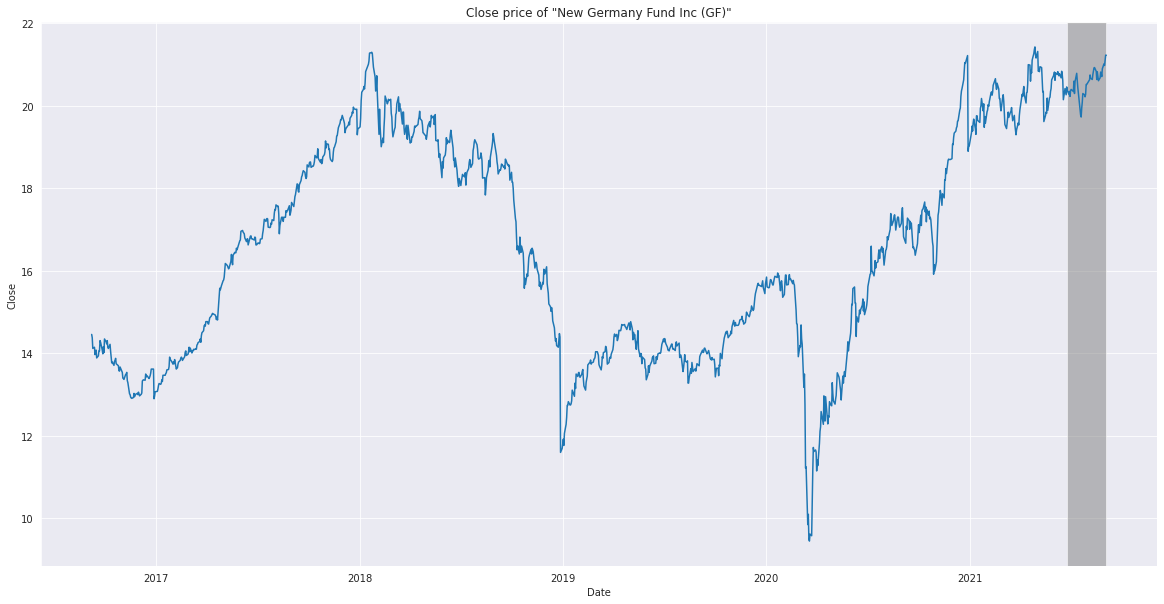

In [6]:
fig, ax = plt.subplots(figsize=[20, 10])
sns.lineplot(data=df_gf, y='Close', x=df_gf.index)
_ = plt.title('Close price of "New Germany Fund Inc (GF)"')

testSZ =50
ax.axvspan(df_gf.index[-testSZ-1], df_gf.index[-1], alpha=0.5, facecolor='grey')

# **Part 2: Stationarity Transformation**

## 2.1 Augmented *Dickey-Fuller* testing

In [7]:
def adf_test(series):
  test = adfuller(series)
  out = pd.Series(test[:4], index=['Test Statistic',
                                    'p-value',
                                    '#Lags Used',
                                    'Number of Observations Used'])
  for key, value in test[4].items():
      out[f'Critical Value ({key}))'] = value
  #print(f'Results of Dickey-Fuller Test:\n{"="*40}')
  #print(out)
  return out

adf_test(df_gf.Close)

Test Statistic                   -1.170986
p-value                           0.685951
#Lags Used                        6.000000
Number of Observations Used    1251.000000
Critical Value (1%))             -3.435588
Critical Value (5%))             -2.863853
Critical Value (10%))            -2.568002
dtype: float64

## 2.2 Moving Average

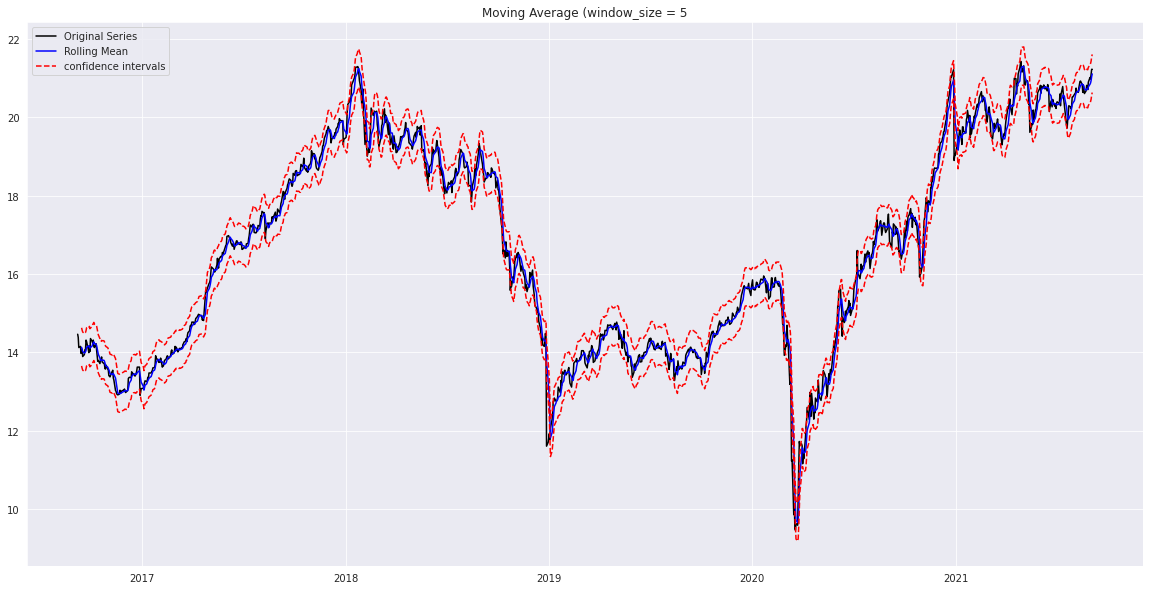

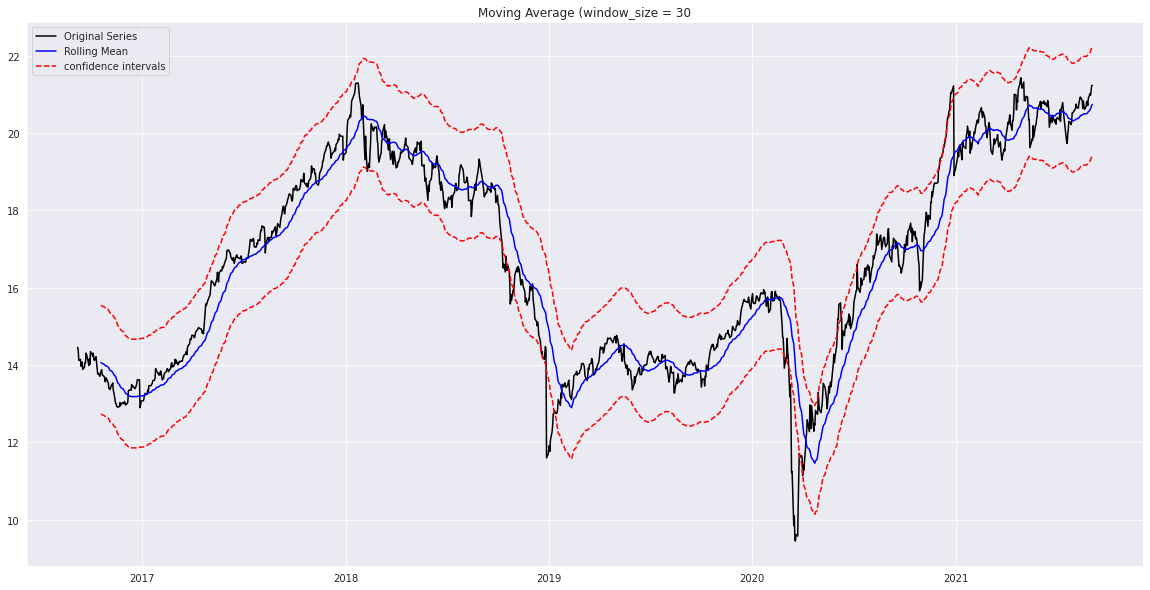

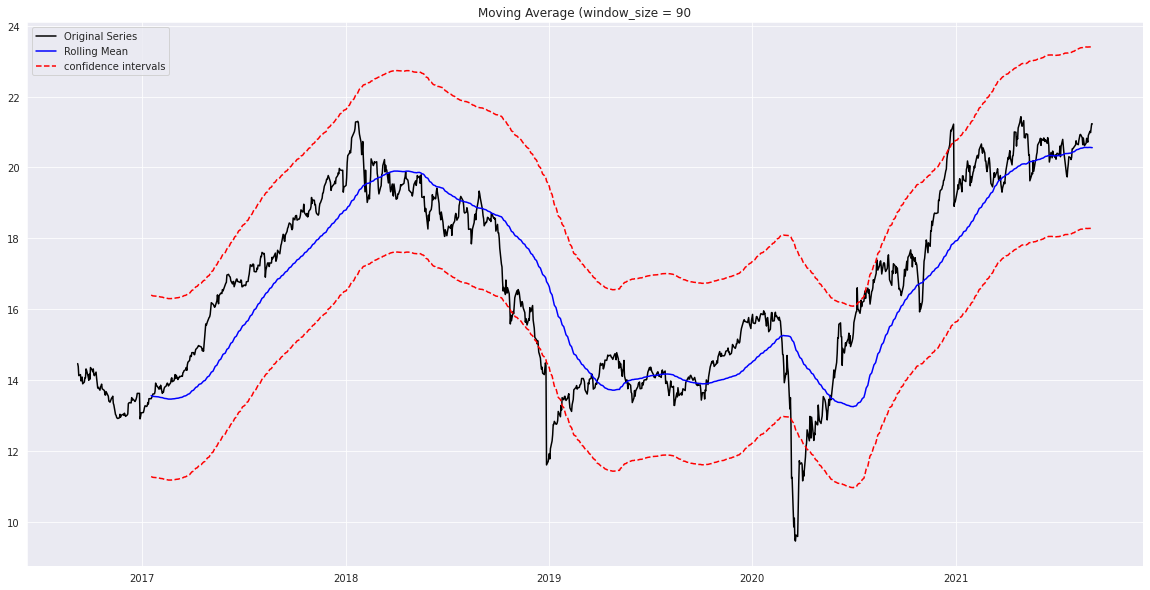

In [8]:
def movAvg(series, window=12, confidence_interval=False, scale=1.96):
  
  # time_series data: [pd.Series, tsNM]
  roll_mean = series.rolling(window).mean()
  roll_std = series.rolling(window).std()

  # Visualization of rolling statistics
  fig = plt.figure(figsize=[20, 10])
  plt.plot(series, 'k', label='Original Series')
  plt.plot(roll_mean[window:], 'b', label='Rolling Mean')
  if confidence_interval:
    res_mean = (series[window:] - roll_mean[window:]).mean()
    res_std = np.std(series[window:] - roll_mean[window:])
    lbound = roll_mean[window:] + res_mean - res_std * scale
    ubound = roll_mean[window:] + res_mean + res_std * scale
    plt.plot(lbound, 'r--', label='confidence intervals')
    plt.plot(ubound, 'r--')
    #print(res_mean)

  plt.legend(loc='best')
  plt.title(f'Moving Average (window_size = {window})')

movAvg(df_gf.Close, 5, confidence_interval=True)
movAvg(df_gf.Close, 30, confidence_interval=True)
movAvg(df_gf.Close, 90, confidence_interval=True)

## 2.3 Exponential Smoothing

$y_0 = x_0$

$y_t = \alpha x_t + (1-\alpha)y_{t-1}$

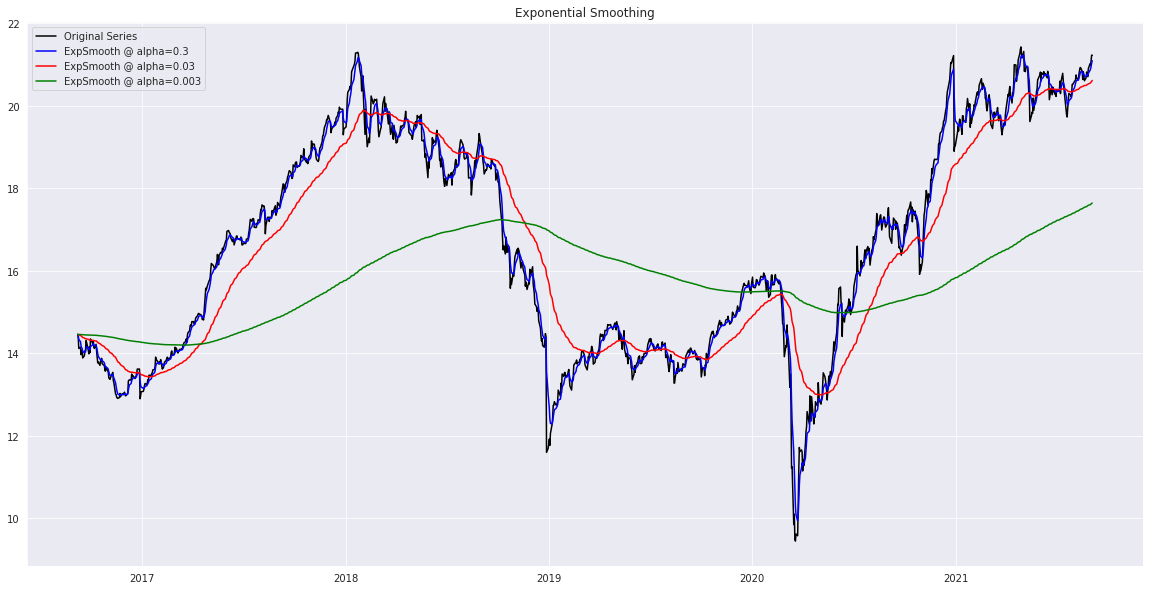

In [9]:
def expSmooth(series, alpha):
  res = [series[0]]
  for i in range(1, len(series)):
    res.append(alpha * series[i] + (1 - alpha) * res[-1])
  res = pd.Series(res, index=series.index)
  return res

def plotExpSmooth(series, alphas, colors='brgcyo'):
  fig = plt.figure(figsize=[20, 10])
  plt.plot(series, 'k', label='Original Series')
  for i in range(len(alphas)):
    res = expSmooth(series, alphas[i])
    plt.plot(res, colors[i], label=f'ExpSmooth @ alpha={alphas[i]}')
  plt.legend(loc='best')
  plt.title('Exponential Smoothing')

plotExpSmooth(df_gf.Close, [0.3, 0.03, 0.003])

## 2.4 Double Exponential Smoothing

$l_0 = x_0$, $b_0 = x_1 - x_0$

$l_t = \alpha x_t + (1-\alpha) (l_{t-1} + b_{t-1})$

$b_t = \beta(l_t - l_{t-1}) + (1-\beta)b_{t-1}$

$y_t = l_t + b_t$

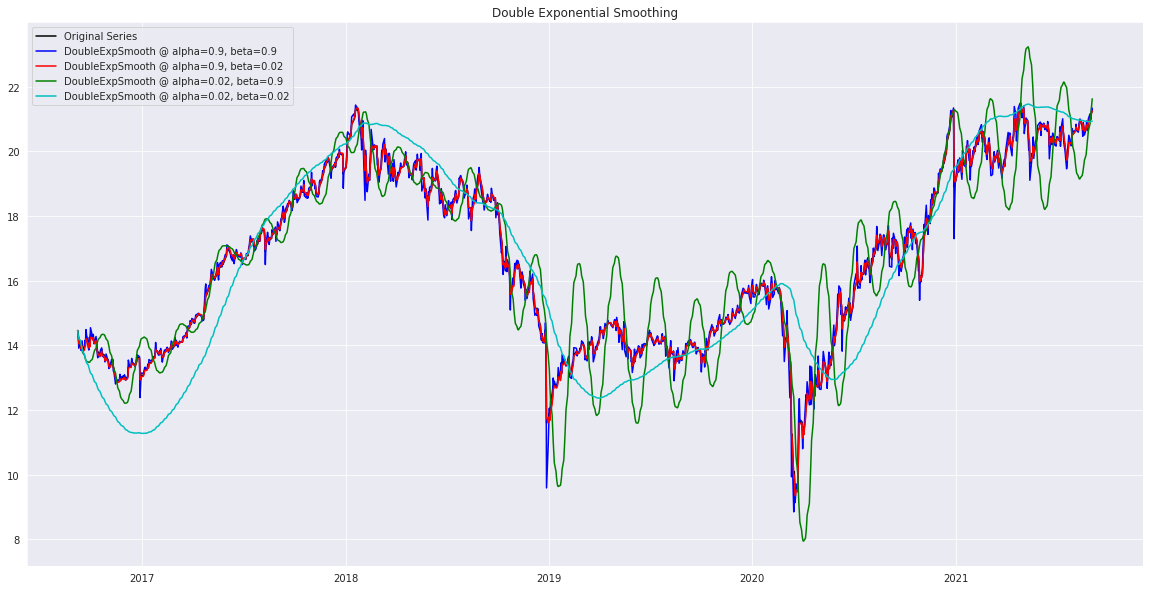

In [10]:
def doubleExpSmooth(series, alpha, beta):
  res = [series[0]]
  level, trend = series[0], series[1] - series[0]
  for i in range(1, len(series)):
    level_new = alpha * series[i] + (1 - alpha) * (level + trend)
    trend = beta * (level_new - level) + (1 - beta) * trend
    level = level_new
    res.append(level + trend)
  res = pd.Series(res, index=series.index)
  return res

def plotDoubleExpSmooth(series, alphas, betas, colors='brgcyo'):
  fig = plt.figure(figsize=[20, 10])
  plt.plot(series, 'k', label='Original Series')
  cnt = 0
  for i in range(len(alphas)):
    for j in range(len(betas)):
      res = doubleExpSmooth(series, alphas[i], betas[j])
      plt.plot(res, colors[cnt], label=f'DoubleExpSmooth @ alpha={alphas[i]}, beta={betas[j]}')
      cnt += 1
  plt.legend(loc='best')
  plt.title('Double Exponential Smoothing')

plotDoubleExpSmooth(df_gf.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

<!-- ## 2.5 Triple Exponential Soothing
- $\alpha$: smoothing factor
- $\beta$: trend smoothing factor
- $\gamma$: seasonal smoothing factor
- L: length of the season

$y_t = \alpha\frac{x_t}{c_{t-L}}+(1-\alpha)(y_{t-1}+b_{t-1})$

$b_t = \beta(y_t - y_{t-1}) + (1-\beta)b_{t-1}$

$c_t = \gamma\frac{x_t}{y_t}+(1-\gamma)c_{t-L}$ -->

# **Part 3: Modelling**

## 3.1 ADF testing, ACF/PACF plotting

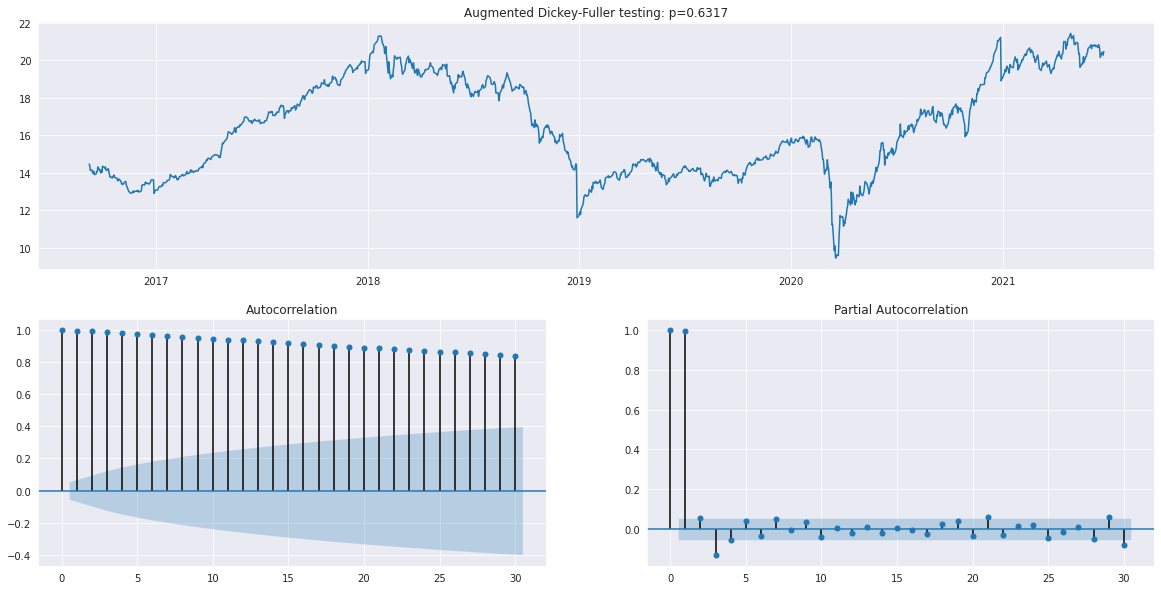

In [11]:
import statsmodels.tsa.api as smt

def plot_series(series, lags=None):
  fig = plt.figure(figsize=[20, 10])
  
  ts_ax = plt.subplot(2, 1, 1)
  adf = adf_test(series)
  ts_ax.plot(series)
  ts_ax.set_title(f'Augmented Dickey-Fuller testing: p={adf["p-value"]:.4f}')

  acf_ax = plt.subplot(2, 2, 3)
  pacf_ax = plt.subplot(2, 2, 4)
  smt.graphics.plot_acf(series, lags=lags, ax=acf_ax)
  smt.graphics.plot_pacf(series, lags=lags, ax=pacf_ax)

plot_series(df_gf.Close[:-testSZ], lags=30)

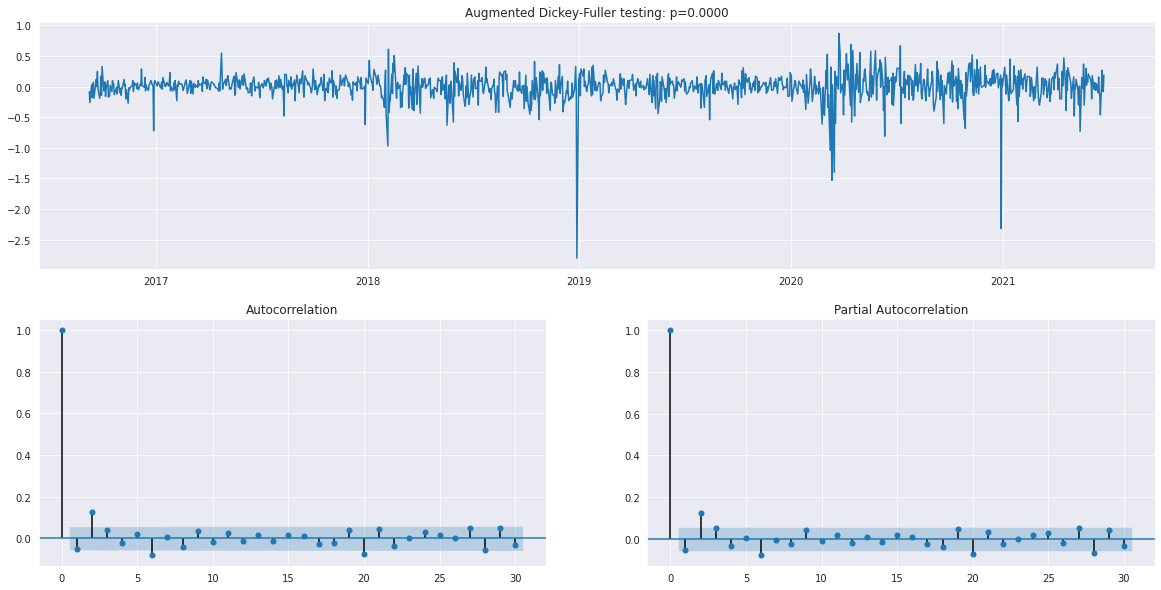

In [12]:
diff_1 = df_gf.Close[:-testSZ] - df_gf.Close[:-testSZ].shift(1)
plot_series(diff_1[1:], lags=30)

## 3.2 SARIMA model

In [13]:
from itertools import product
import statsmodels.api as sm

# Train SARIMA models to find the best one
def optimize_SARIMA(series, paras, d, D, s):
  res = []
  best_aic = float('inf')
  for para in paras:
    try:
      model = sm.tsa.statespace.SARIMAX(series, order=(para[0], d, para[1]),
                                        seasonal_order=(para[2], D, para[3], s)).fit(disp=-1)
    except:
      continue

    aic = model.aic
    if aic < best_aic:
      best_model = model
      best_aic = aic
      best_para = para
    res.append([para, aic])
  
  df_res = pd.DataFrame(res, columns=['params', 'aic'])
  df_res = df_res.sort_values(by='aic', ascending=True).reset_index(drop=True)
  return df_res, best_model

# set p, d, q, P, D, Q, s range
ps = range(1, 7)
d = 1
qs = range(1, 7)
Ps = range(0, 2)
D = 0
Qs = range(0, 2)
s = 5

paras = product(ps, qs, Ps, Qs)
paras = list(paras)
print(f'There are {len(paras)} different params comb')

df_res, best_model = optimize_SARIMA(df_gf.Close[:-testSZ], paras, d, D, s)
print(best_model.summary())
print(df_res)

There are 144 different params comb
                           Statespace Model Results                           
Dep. Variable:                  Close   No. Observations:                 1208
Model:               SARIMAX(3, 1, 1)   Log Likelihood                 104.105
Date:                Thu, 09 Sep 2021   AIC                           -198.211
Time:                        06:07:00   BIC                           -172.732
Sample:                             0   HQIC                          -188.616
                               - 1208                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9937      0.028    -35.890      0.000      -1.048      -0.939
ar.L2          0.0850      0.030      2.816      0.005       0.026       0.144
ar.L3          0

### The residuals of the Best Model

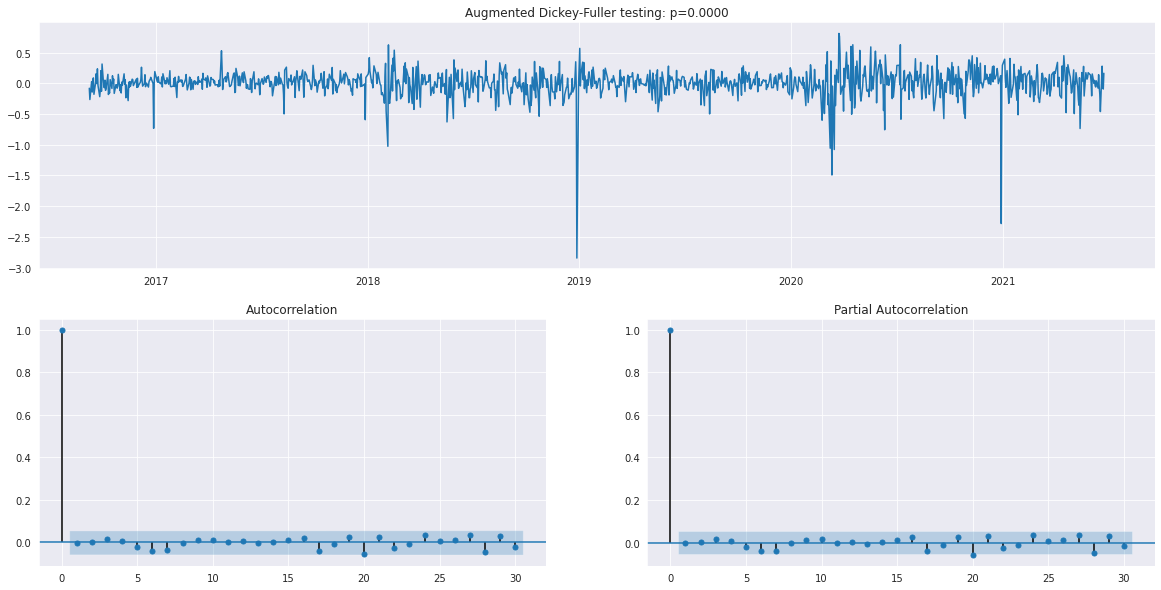

In [14]:
plot_series(best_model.resid[1:], lags=30)

### Make predictions with the best model

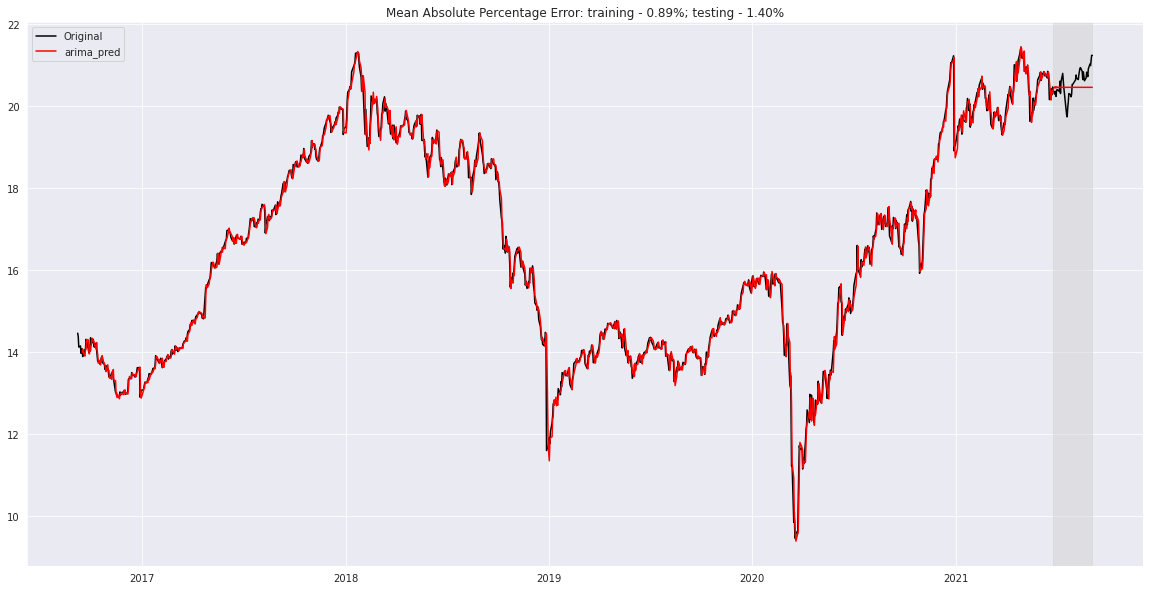

In [15]:
def SARIMA_pred(series, model, testSZ, offset=2):
  pred = pd.DataFrame()
  pred['Original'] = series
  pred['arima_pred'] = model.fittedvalues
  pred['arima_pred'][:offset] = np.NaN
  mae_perc = np.mean(np.abs(pred['Original'][offset:] - pred['arima_pred'][offset:]) / pred['Original'][offset:]) * 100

  y = model.predict(start=pred.shape[0]-testSZ, end=pred.shape[0]-1)
  pred.arima_pred[-testSZ:] = y
  mae_perc_test = np.mean(np.abs(pred['Original'][-testSZ:] - pred['arima_pred'][-testSZ:]) / pred['Original'][-testSZ:]) * 100
  
  fig = plt.figure(figsize=[20, 10])
  plt.plot(pred['Original'], 'k', label='Original')
  plt.plot(pred['arima_pred'], 'r', label='arima_pred')
  plt.axvspan(pred.index[-testSZ], pred.index[-1], alpha=0.5, color='lightgrey')
  plt.title(f'Mean Absolute Percentage Error: training - {mae_perc:.2f}%; testing - {mae_perc_test:.2f}%')
  plt.legend(loc='best')

SARIMA_pred(df_gf.Close, best_model, testSZ, s+d)